In [4]:
print('Nama                 : Aldi Akbar Alimi')
print('Username dicoding    : alldinosaur')
print('Email                : aldiakbar373@gmail.com')
print('Domisili             : Kab. Cirebon')
print('TTL                  : Brebes, 25 Juni 2001')
print('Pendidikan Terakhir  : SMA Negeri 1 Brebes')
print('Pendidikan Sekarang  : STT Terpadu Nurul Fikri')

Nama                 : Aldi Akbar Alimi
Username dicoding    : alldinosaur
Email                : aldiakbar373@gmail.com
Domisili             : Kab. Cirebon
TTL                  : Brebes, 25 Juni 2001
Pendidikan Terakhir  : SMA Negeri 1 Brebes
Pendidikan Sekarang  : STT Terpadu Nurul Fikri


In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.model_selection import train_test_split

from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential

In [6]:
df_visualize = pd.read_csv('DOM_hourly.csv', index_col='Datetime', parse_dates=['Datetime'])
df = pd.read_csv('DOM_hourly.csv')
df.head()

,Datetime,DOM_MW
0,2005-12-31 01:00:00,9389.0
1,2005-12-31 02:00:00,9070.0
2,2005-12-31 03:00:00,9001.0
3,2005-12-31 04:00:00,9042.0
4,2005-12-31 05:00:00,9132.0


In [7]:
#checking missing data
df.isna().sum()

Datetime    0
DOM_MW      0
dtype: int64

In [8]:
df.shape

(116189, 2)

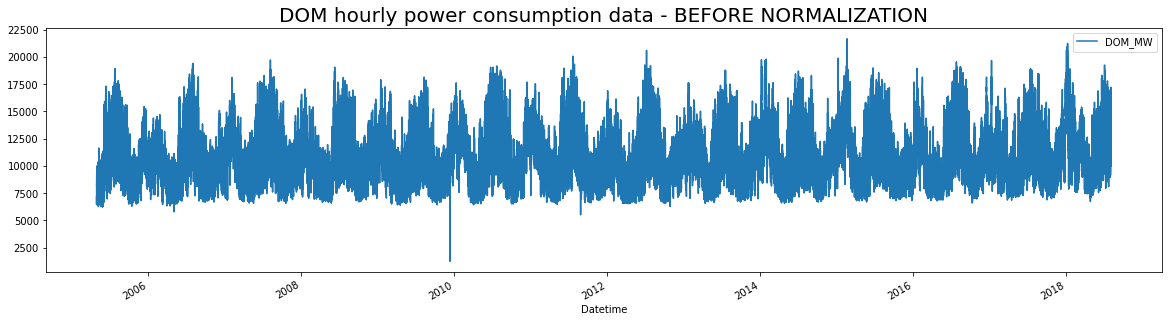

In [9]:
df_visualize.plot(figsize=(20,5),legend=True)
plt.title('DOM hourly power consumption data - BEFORE NORMALIZATION',
          fontsize=20);
plt.show()

In [10]:
def normalize_data(df):
    scaler = sklearn.preprocessing.MinMaxScaler()
    df['DOM_MW']=scaler.fit_transform(df['DOM_MW'].values.reshape(-1,1))
    df_visualize['DOM_MW']=scaler.fit_transform(df_visualize['DOM_MW'].values.reshape(-1,1))
    return df

df_norm = normalize_data(df)

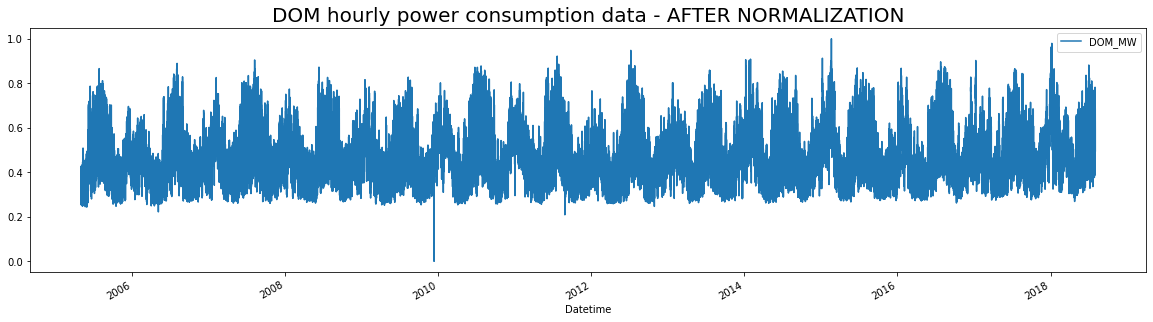

In [11]:
df_visualize.plot(figsize=(20,5),legend=True)
plt.title('DOM hourly power consumption data - AFTER NORMALIZATION',
          fontsize=20);
plt.show()

In [12]:
class Callback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('mae')<0.1):
            print("\n Nilai MAE telah dibawah 10%") 
            self.model.stop_training = True 
 
callbacks = Callback()

In [13]:
Datetime = df['Datetime'].values
DOM_MW = df['DOM_MW'].values

In [14]:
Date_latih, Date_test, DOM_MW_latih, DOM_MW_test = train_test_split(Datetime, DOM_MW, test_size=0.2)

In [15]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [16]:
train_set = windowed_dataset(DOM_MW_latih, window_size=60, batch_size=1000, shuffle_buffer=1000)
test_set = windowed_dataset(DOM_MW_test, window_size=60, batch_size=1000, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, activation="tanh", return_sequences=True),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.LSTM(60, activation="tanh"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [17]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,
                    epochs=10, 
                    validation_data=test_set, 
                    verbose=2,
                    callbacks=[callbacks])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/10
93/93 - 23s - loss: 0.0989 - mae: 0.4276 - val_loss: 0.0779 - val_mae: 0.3765 - 23s/epoch - 245ms/step
Epoch 2/10
93/93 - 15s - loss: 0.0644 - mae: 0.3377 - val_loss: 0.0504 - val_mae: 0.2943 - 15s/epoch - 165ms/step
Epoch 3/10
93/93 - 13s - loss: 0.0422 - mae: 0.2642 - val_loss: 0.0328 - val_mae: 0.2268 - 13s/epoch - 143ms/step
Epoch 4/10
93/93 - 13s - loss: 0.0280 - mae: 0.2043 - val_loss: 0.0218 - val_mae: 0.1737 - 13s/epoch - 143ms/step
Epoch 5/10
93/93 - 13s - loss: 0.0193 - mae: 0.1600 - val_loss: 0.0153 - val_mae: 0.1378 - 13s/epoch - 144ms/step
Epoch 6/10
93/93 - 13s - loss: 0.0141 - mae: 0.1305 - val_loss: 0.0115 - val_mae: 0.1149 - 13s/epoch - 145ms/step
Epoch 7/10
93/93 - 14s - loss: 0.0111 - mae: 0.1126 - val_loss: 0.0094 - val_mae: 0.1017 - 14s/epoch - 154ms/step
Epoch 8/10
93/93 - 13s - loss: 0.0094 - mae: 0.1028 - val_loss: 0.0083 - val_mae: 0.0956 - 13s/epoch - 143ms/step
Epoch 9/10

 Nilai MAE telah dibawah 10%
93/93 - 13s - loss: 0.0085 - mae: 0.0980 - val_

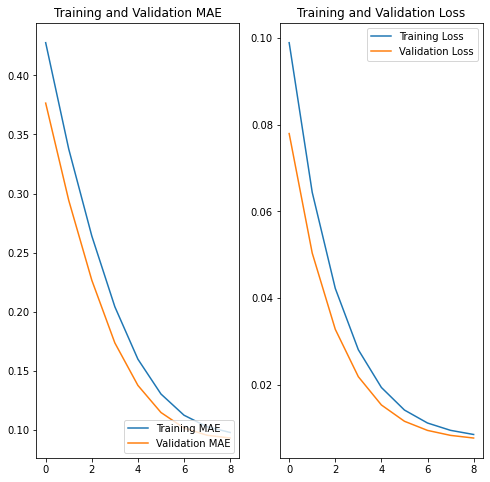

In [18]:
mae = history.history['mae']
val_mae = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()